In [1]:
import theano
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-24 14:37:07.284645
numcores: 28


In [2]:
print(os.getcwd())
if 'aglinsai' in os.getcwd():
    in_dir='/gsfs0/data/aglinsai/roi_paper_data'
    print('Im on cluster')
elif 'aidasaglinskas' in os.getcwd():
    in_dir='/Users/aidasaglinskas/Desktop/roi_paper_data/'
    print('Im on local')
else:
    raise(Exception('I dont know where I am'))

print(in_dir)

/gsfs0/data/aglinsai/BC-BNP/NoteBooks
Im on cluster
/gsfs0/data/aglinsai/roi_paper_data


In [3]:
i = 0

temp = os.listdir(in_dir)
cmat_files = [file for file in temp if 'cmat' in file]
proportion_files = [file for file in temp if 'proportion' in file]
subs_files = [file for file in temp if 'subs' in file]
cmat_files.sort()
proportion_files.sort()
subs_files.sort()

[print(file) for file in cmat_files]
print('______')
[print(file) for file in proportion_files]
print('______')
[print(file) for file in subs_files]


cmat_fn = os.path.join(in_dir,cmat_files[i])
proportionMat_fn = os.path.join(in_dir,proportion_files[i])
subs_fn = os.path.join(in_dir,subs_files[i])
cmats = np.load(cmat_fn)
proportionMat = np.load(proportionMat_fn)
subs = np.load(subs_fn)

subs=subs['arr_0']
proportionMat = proportionMat['arr_0']
cmats = cmats['arr_0']

nsubs=cmats.shape[0]
nmasks=cmats.shape[1]
conn=np.zeros((nsubs,nmasks,1275))

for s in range(nsubs):
    for m in range(nmasks):
        conn[s,m,:]=cmats[s,m,:,:][np.triu_indices(51,1)]

print(cmat_fn)
print(cmats.shape)
print(proportionMat_fn)
print(proportionMat.shape)
print(subs_fn)
print(subs.shape)
print('conn shape')
print(conn.shape)

#proportionMat[s,m,:] = perc
#cmat[s,m,:,:]

pmask2_3001_cmats_121_task-rest.npz
pmask_3001_cmats_127_task-face.npz
pmask_3001_cmats_127_task-rest.npz
rMask_3001_cmats_105_task-rest.npz
______
pmask2_3001_proportionMat_121_task-rest.npz
pmask_3001_proportionMat_127_task-face.npz
pmask_3001_proportionMat_127_task-rest.npz
rMask_3001_proportionMat_105_task-rest.npz
______
pmask2_3001_subs_121_task-rest.npz
pmask_3001_subs_127_task-face.npz
pmask_3001_subs_127_task-rest.npz
rMask_3001_subs_105_task-rest.npz
/gsfs0/data/aglinsai/roi_paper_data/pmask2_3001_cmats_121_task-rest.npz
(121, 51, 51, 51)
/gsfs0/data/aglinsai/roi_paper_data/pmask2_3001_proportionMat_121_task-rest.npz
(121, 51, 51)
/gsfs0/data/aglinsai/roi_paper_data/pmask2_3001_subs_121_task-rest.npz
(121,)
conn shape
(121, 51, 1275)


In [4]:
data = conn[:,0,:]
nsamples=data.shape[0]
ndim=data.shape[1]

In [5]:
# m = [1,2,3];sd=[1,1,1];cov=np.eye(len(sd))*sd;
# data1=pm.MvNormal.dist(mu=m,cov=cov).random(size=2000)

# m = [7,8,9];sd=[1,1,1];cov=np.eye(len(sd))*sd;
# data2=pm.MvNormal.dist(mu=m,cov=cov).random(size=1000)

# #m = [15,16,17];sd=[1,1,1];cov=np.eye(len(sd))*sd;
# #data3=pm.MvNormal.dist(mu=m,cov=cov).random(size=100)

# data=np.vstack((data1,data2))

# nsamples=data.shape[0]
# ndim=data.shape[1]

# print('Multivariate Data, 2 clusters, 123 ; 789,100 each')
# print(data.shape)

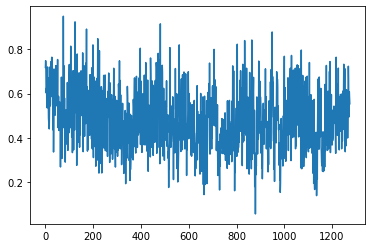

In [6]:
plt.plot(data.mean(axis=0))

In [7]:
# Working model, inferring mus 
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(beta))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    mus=[pm.Uniform('mu{}'.format(i),-1,1,shape=ndim) for i in range(infinity)]
    components = [pm.MvNormal.dist(mu=mus[i], cov=np.eye(ndim), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [8]:
nsamples=5000
ntune=1000
ncores=8


trace = pm.sample(draws=nsamples,tune=ntune,cores=ncores,init='auto',n_init=20,model=model)
print(pm.summary(trace));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu4, mu3, mu2, mu1, mu0, beta, alpha]
Sampling 8 chains, 3,902 divergences: 100%|██████████| 48000/48000 [13:17:40<00:00,  1.00draws/s]
There were 551 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6830472828853444, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1354 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6624882244419721, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6879385085359437, but should be close to 0.8. Try to increase the number of tuning steps.
There were 626 divergences 

            mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
alpha      1.063  1.257   0.034    3.495      0.328    0.237      15.0   
beta[0]    0.131  0.328   0.001    1.000      0.116    0.085       8.0   
beta[1]    0.598  0.474   0.001    1.000      0.164    0.120       8.0   
beta[2]    0.459  0.424   0.001    1.000      0.125    0.091      12.0   
beta[3]    0.667  0.360   0.003    1.000      0.091    0.066      16.0   
...          ...    ...     ...      ...        ...      ...       ...   
mu4[1270]  0.060  0.561  -0.989    0.865      0.057    0.041      96.0   
mu4[1271]  0.065  0.565  -0.979    0.874      0.061    0.043      86.0   
mu4[1272]  0.075  0.579  -0.996    0.866      0.071    0.051      66.0   
mu4[1273]  0.073  0.574  -0.989    0.873      0.068    0.048      72.0   
mu4[1274]  0.068  0.571  -0.999    0.862      0.065    0.046      78.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
alpha        15.0      14.0      64.0   1.54  
beta[0]       8.0

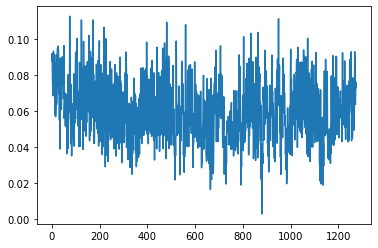

In [9]:
plt.plot(trace['mu0'].mean(axis=0))

<BarContainer object of 5 artists>

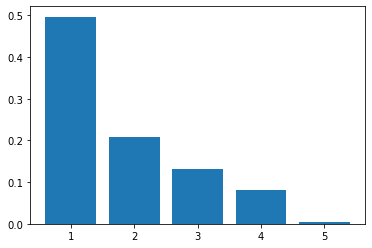

In [10]:
k=np.sort(trace['w'].mean(axis=0))[::-1]
x=np.arange(1,len(k)+1)
plt.bar(x,k)

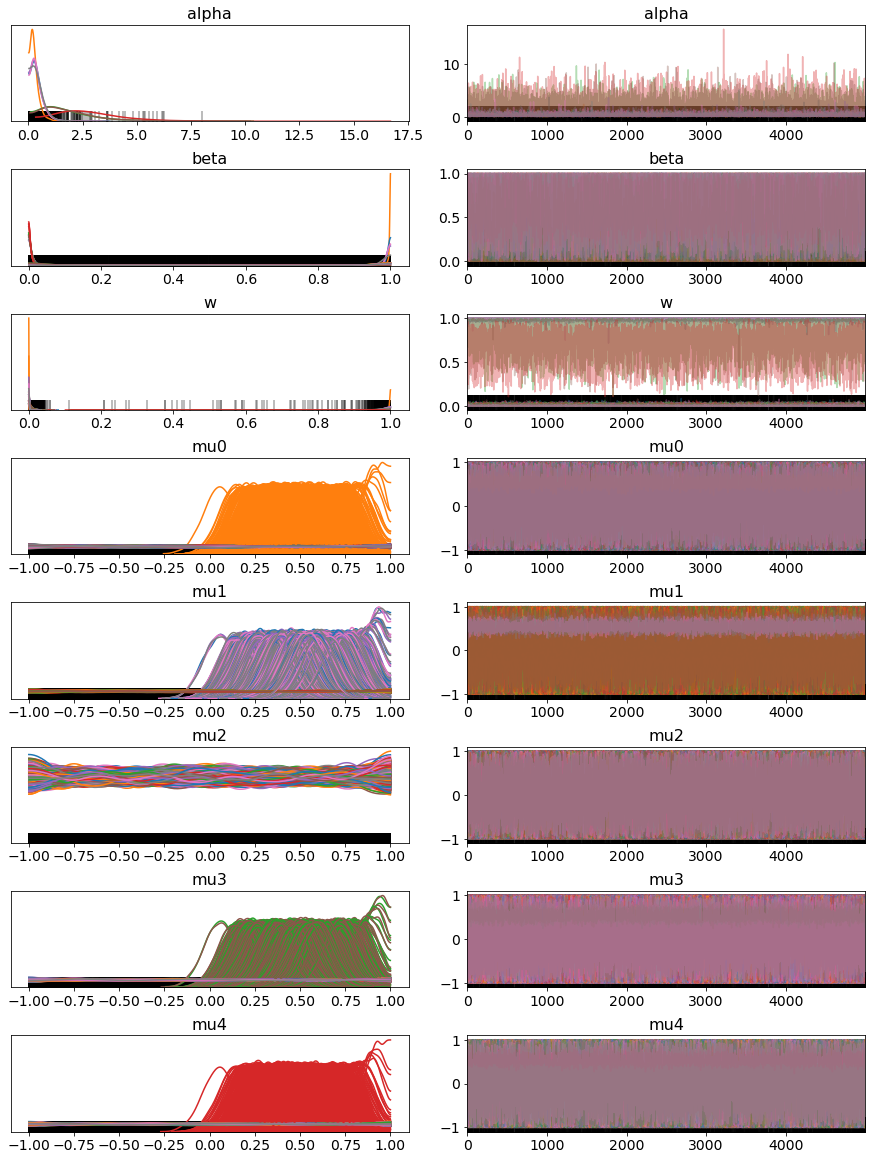

In [11]:
pm.traceplot(trace);

/data/aglinsai/.conda/envs/py3/lib/python3.7/site-packages/arviz/plots/plot_utils.py:506: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (6380) in plot_posterior, generating only 40 plots
  SyntaxWarning,


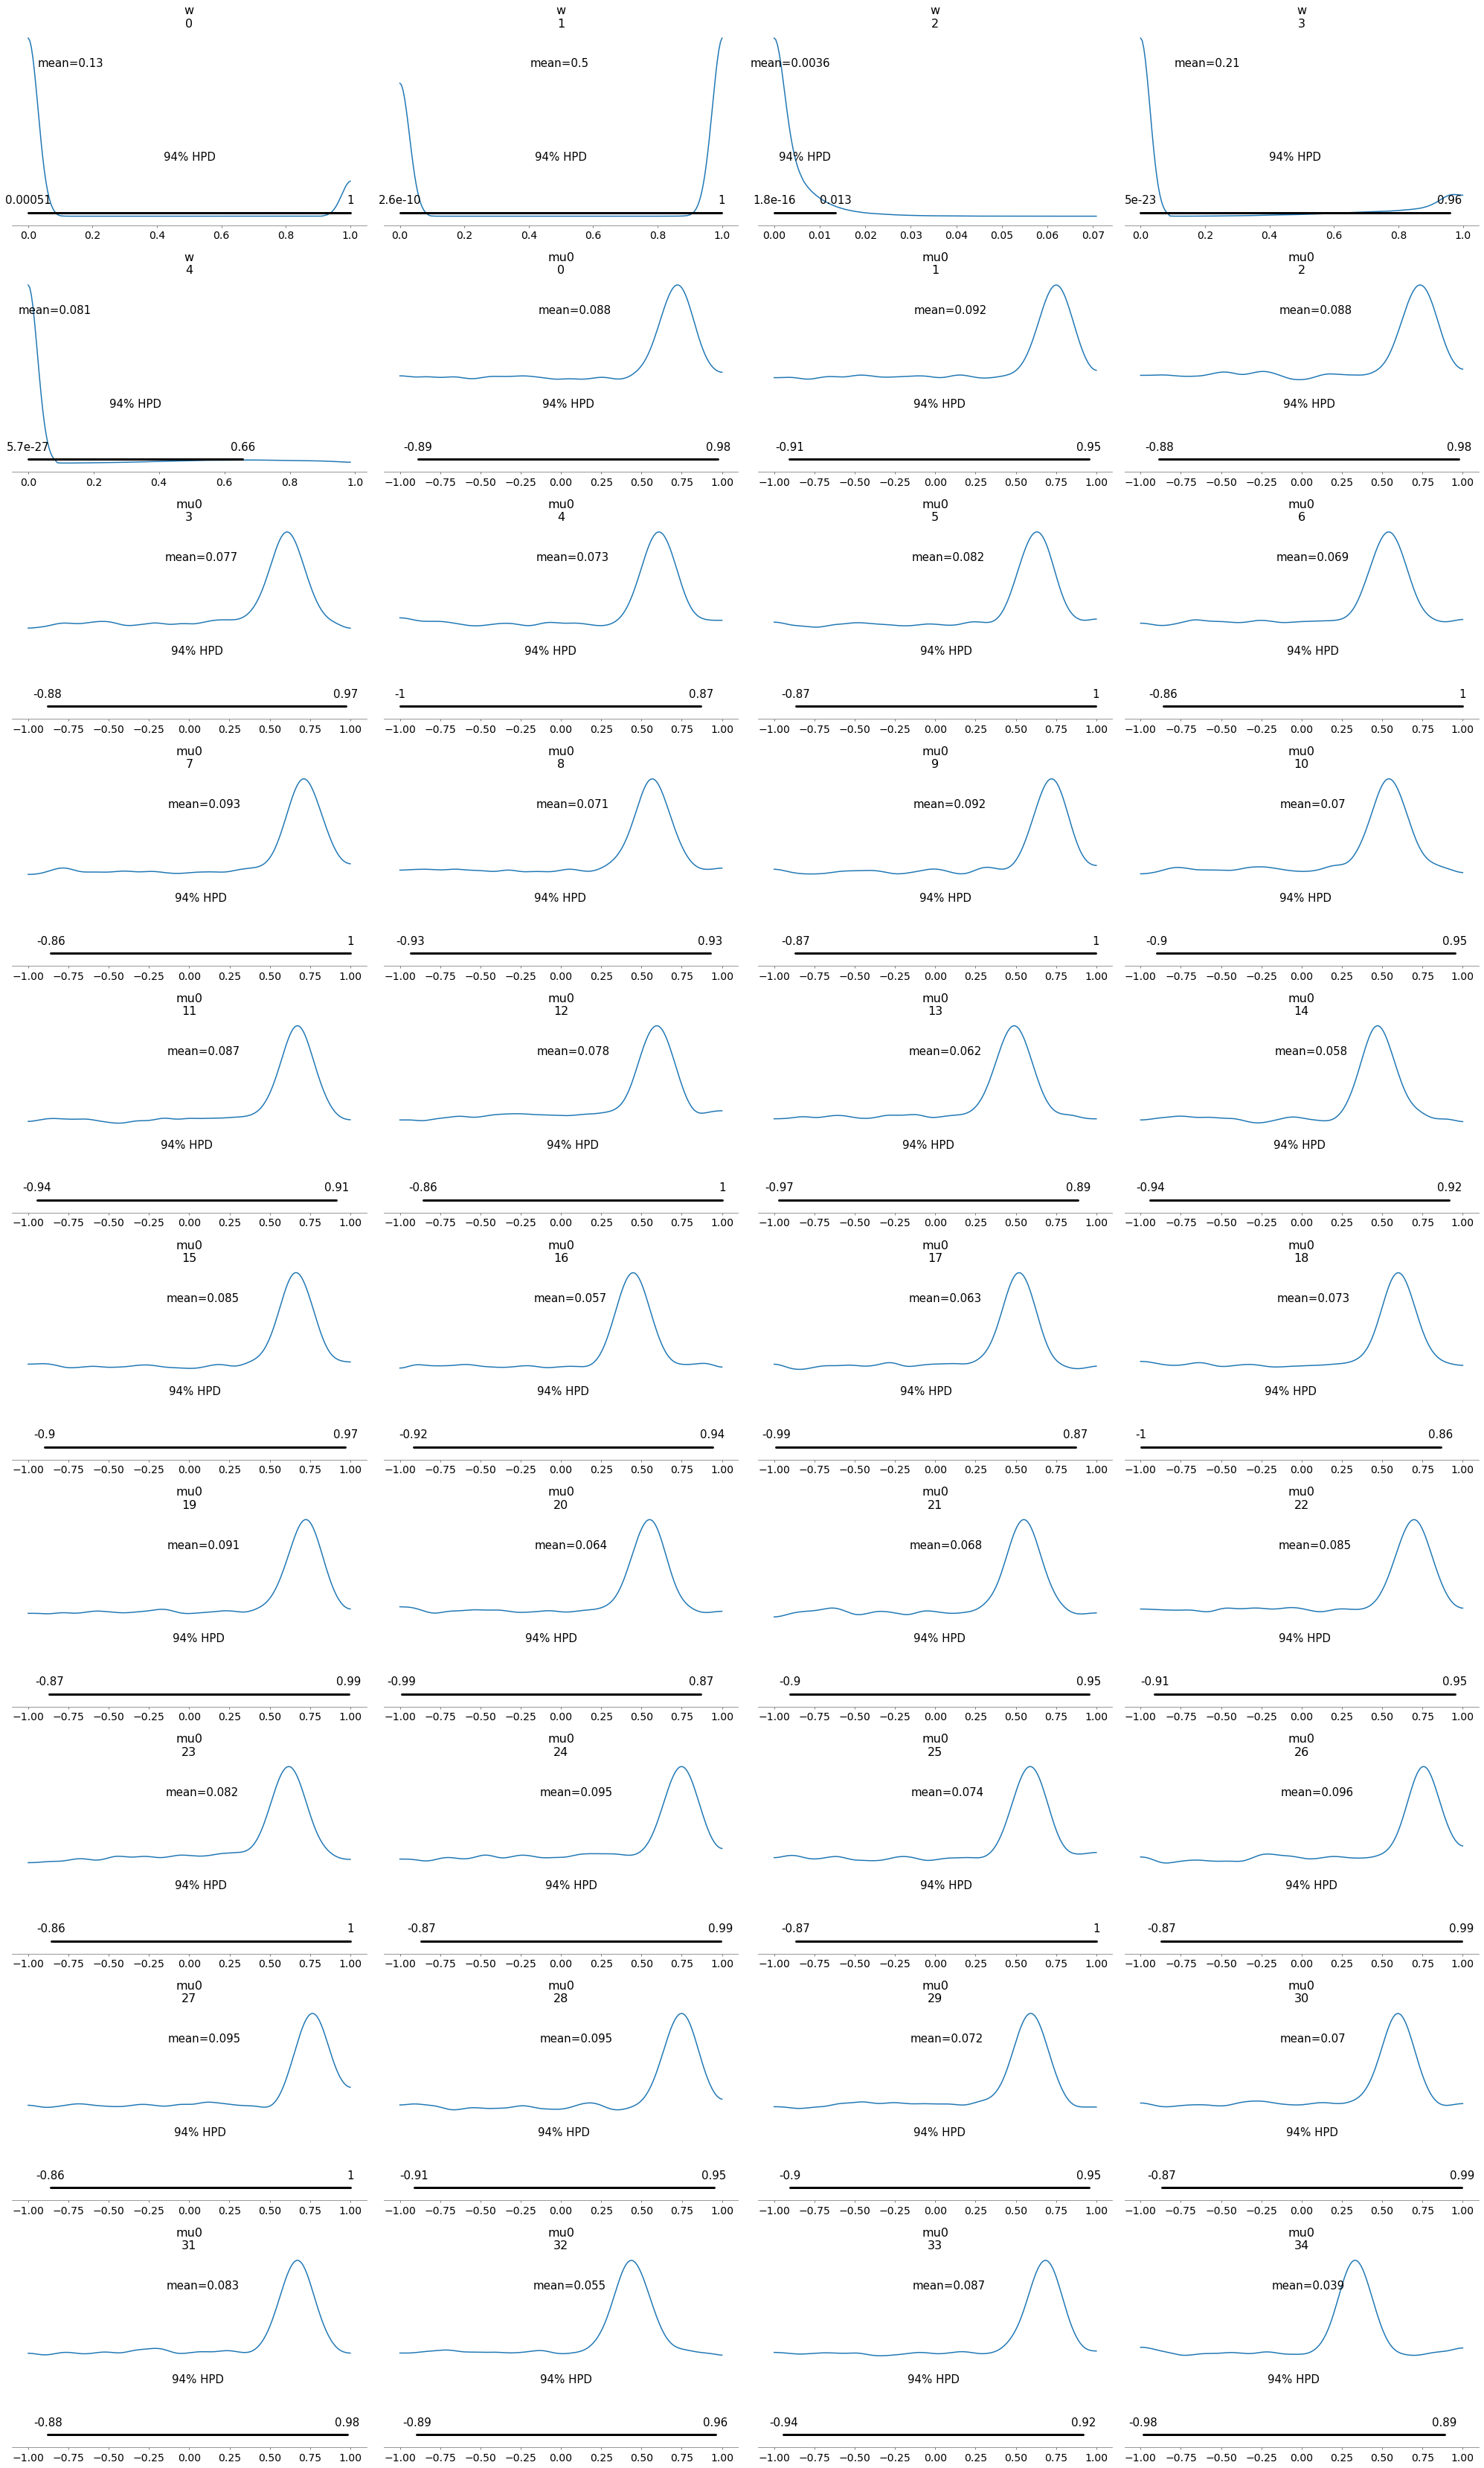

In [12]:
pm.plot_posterior(data=trace,var_names=['w','mu0','mu1','mu2','mu3','mu4']);

In [13]:
t_finish=now()

In [14]:
print('Time it took to run {}'.format(str(t_finish-t_start)))

Time it took to run 15:21:59.765292


In [15]:
#with model:
#    trace = pm.sample(draws=5000,cores=8,tune=500)    

In [16]:
#with model:
#    trace = pm.find_MAP()